In [29]:
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
import datetime as dt

metrics_path = '../metrics/'
figure_path = 'figures/'

def get_filenames_in_folder(path):
    file_names = [join(path, f) for f in listdir(path) if isfile(join(path, f)) and f.lower().endswith('.csv')]
    file_names.sort()
    return file_names

all_files = get_filenames_in_folder(metrics_path)
print(all_files)

def read_file(path):
    return pd.read_csv(path, comment='#')

if len(all_files) > 0:
    latest_data = read_file(all_files[0])
    print(latest_data.iloc[1])

GLOBAL_STYLE = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans'],
    'font.size': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'axes.axisbelow': True  # grid lines below data
}

FIGURE_SIZE = (12, 7)

LINE_STYLE = {
    "linewidth": 1.5,
    "linestyle": "-"  # solid lines
}

GRID_STYLE = {
    "visible": True,
    "linestyle": "--",
    "alpha": 0.6
}

plt.rcParams.update(GLOBAL_STYLE)

['../metrics/2025-07-22_12-14-16_metrics.csv']
timestamp    2025-07-22T12:13:25.567689+00:00
field                               memory_mb
value                                  172.76
node                                   node_1
Name: 1, dtype: object


[0.001      0.00242978 0.00590384 0.01434503 0.03485528 0.0846907
 0.20577986 0.5       ]
8
[np.float64(29.268757581710812), np.float64(38.39942932128906), np.float64(48.57884383201599), np.float64(63.49082589149475), np.float64(64.23046016693115), np.float64(66.81489729881287), np.float64(67.95142030715942), np.float64(68.2221622467041)]


/tmp/ipykernel_2135/1338472511.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


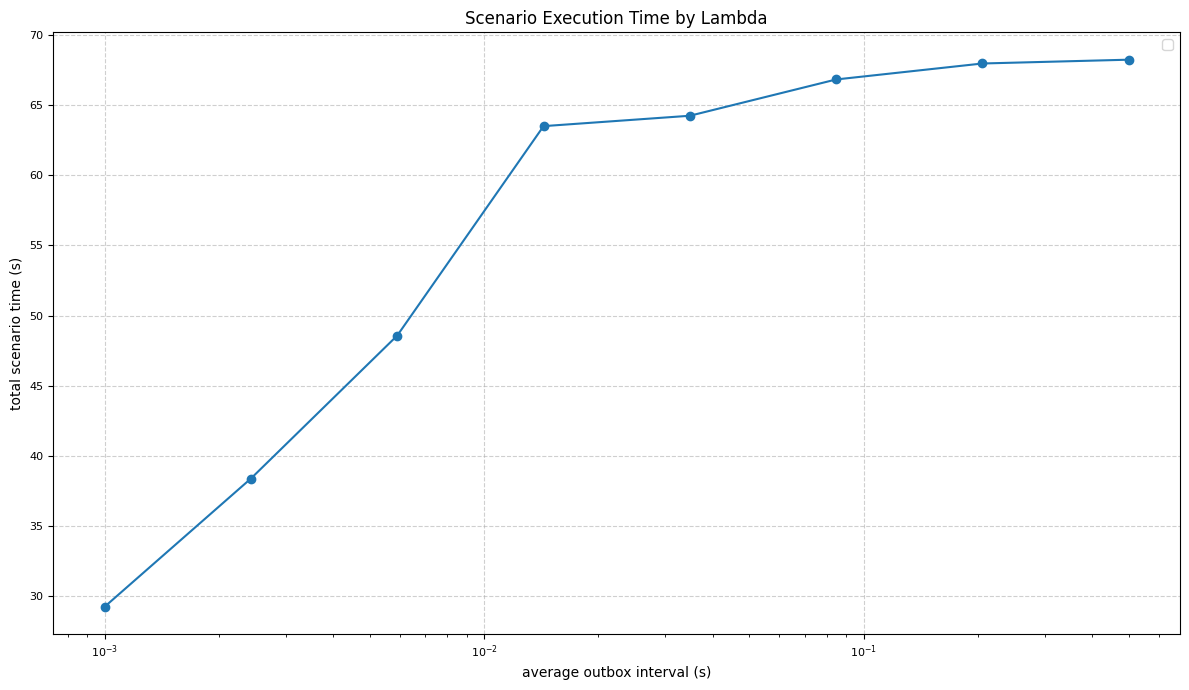

In [30]:
# Time per scenario
# 10 rounds
# y: time per whole scenario
# x: delay in seconds

lambdas = np.logspace(np.log10(0.001), np.log10(0.5), num=8)
print(lambdas)

rt_files = get_filenames_in_folder(join(metrics_path, "run_time"))

def deserizalize_time(str_time):
    return dt.datetime.fromisoformat(str_time)

def get_duration(df):
    filtered_df = df.loc[df['field'] == "round_time"]
    return filtered_df['value'].max()

df_rt_files = [read_file(f) for f in rt_files]
rt_list = [get_duration(df) for df in df_rt_files]
print(len(rt_list))
print(rt_list)

plt.figure(figsize=FIGURE_SIZE)           # Optional: set figure size
plt.plot(lambdas[:len(rt_list)], rt_list, marker='o')

# Add labels and title
plt.xlabel('average outbox interval (s)')
plt.xscale('log')
plt.ylabel('total scenario time (s)')
plt.title('Scenario Execution Time by Lambda')

# Add grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig(join(figure_path, "time-per-scenario.png"))
plt.grid(**GRID_STYLE)
plt.show()


In [31]:
# CPU utilization per state (training, waiting, aggregating, broadcasting)
# y: Total CPU time per stage
# x:
#   - number of batches     
#   - number of nodes       
#   - number of hops        


nr_batches  = [10, 50, 100, 500]
nr_nodes    = [2, 4, 6, 8, 10]
nr_hops     = [1, 2, 3, 4, 5, 6]

stages = {1: "Training", 3: "Broadcasting and Receiving"}
    

def stage_plot(property, title, folder):
    cpu_files = get_filenames_in_folder(join(metrics_path, "cpu_per_stage", folder))
    df_cpu_files = [read_file(f) for f in cpu_files]

    def get_cpu_per_stage(df):
        df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601')

        stage_df = df[df['field'] == 'stage'].copy()
        stage_df = stage_df.sort_values('timestamp')
        stage_df = (
            df[df['field'] == 'stage']
            .sort_values('timestamp')
            .groupby(['value', 'node'], as_index=False)
            .last()
        )
        stage_df = stage_df[stage_df['value'].isin(stages.keys())]

        cpu_df = df[df['field'] == 'cpu_total_ns'].copy()
        cpu_df = cpu_df.sort_values('timestamp')

        results = []

        for _, stage_row in stage_df.iterrows():
            stage_time = stage_row['timestamp']
            stage_num = int(stage_row['value'])
            node = stage_row['node']

            cpu_before_stage = cpu_df[(cpu_df['node'] == node) & (cpu_df['timestamp'] <= stage_time)]

            if not cpu_before_stage.empty:
                latest_cpu = cpu_before_stage.iloc[-1]  # last (latest) row
                results.append({
                    'node': node,
                    'stage': stage_num,
                    'cpu_total_ns': float(latest_cpu['value']),
                    'timestamp': latest_cpu['timestamp']
                })

        cpu_per_stage_df = pd.DataFrame(results)

        cpu_per_stage_df = cpu_per_stage_df.sort_values(['node', 'stage'])

        cpu_per_stage_df['cpu_per_stage'] = cpu_per_stage_df.groupby('node')['cpu_total_ns'].diff().fillna(cpu_per_stage_df['cpu_total_ns'])

        return cpu_per_stage_df

    for df in df_cpu_files:
        get_cpu_per_stage(df)

    cpu_values_per_batch = []

    for df in df_cpu_files:
        stage_df = get_cpu_per_stage(df)

        stage_totals = stage_df.groupby('stage')['cpu_per_stage'].mean()

        cpu_row = [stage_totals.get(stage, 0) for stage in stages.keys()]
        cpu_values_per_batch.append(cpu_row)
        
    property = property[:len(cpu_values_per_batch)]

    data = np.array(cpu_values_per_batch)

    x = np.arange(len(property))
    width = 0.2

    plt.figure(figsize=FIGURE_SIZE)

    for i, stage in enumerate(stages):
        plt.bar(x + i * width, data[:, i], width=width, label=stages[stage])

    plt.xticks(x + width, property)
    plt.xlabel(title)
    plt.ylabel('CPU Ns')
    plt.title('CPU Usage per Stage, ' + title)
    plt.legend(title='Stage')
    plt.savefig(join(figure_path, f"cpu_per_stage_{folder}.png"))
    plt.tight_layout()

    plt.grid(**GRID_STYLE)

    plt.show()

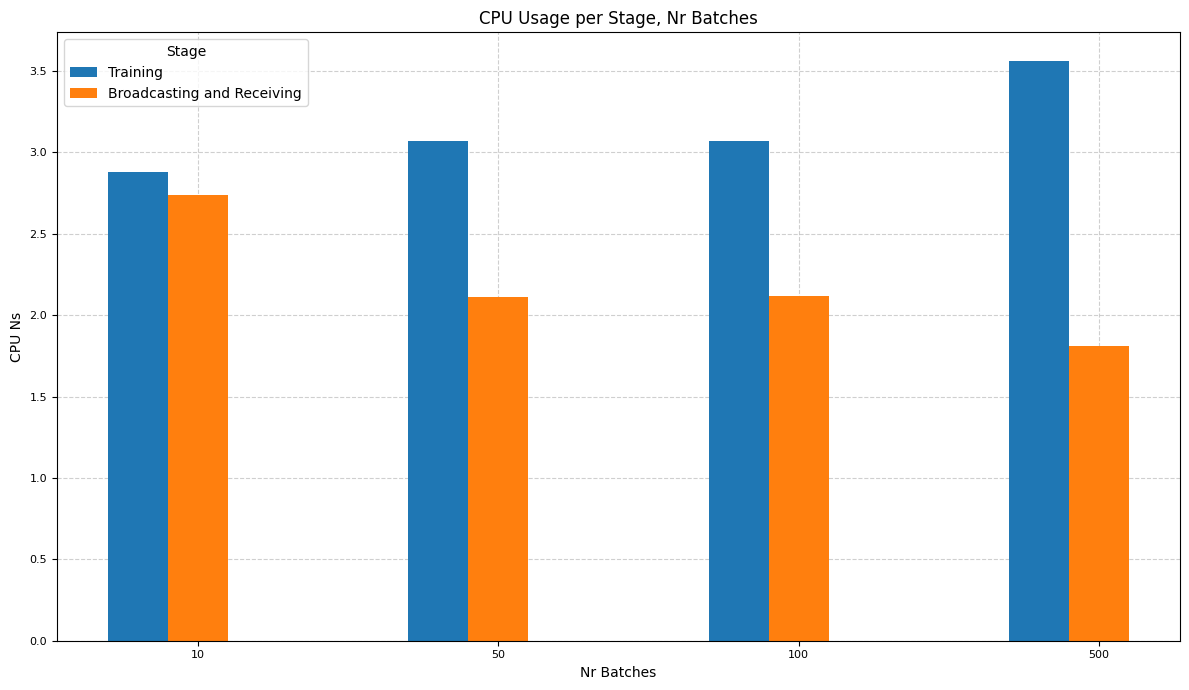

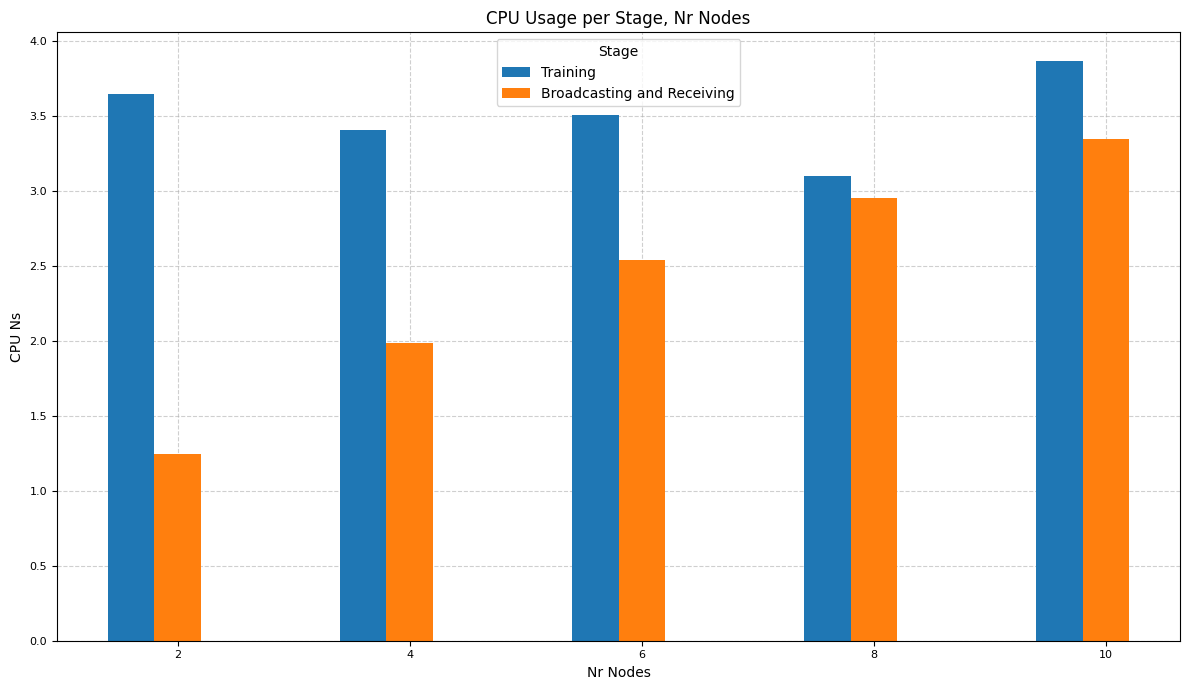

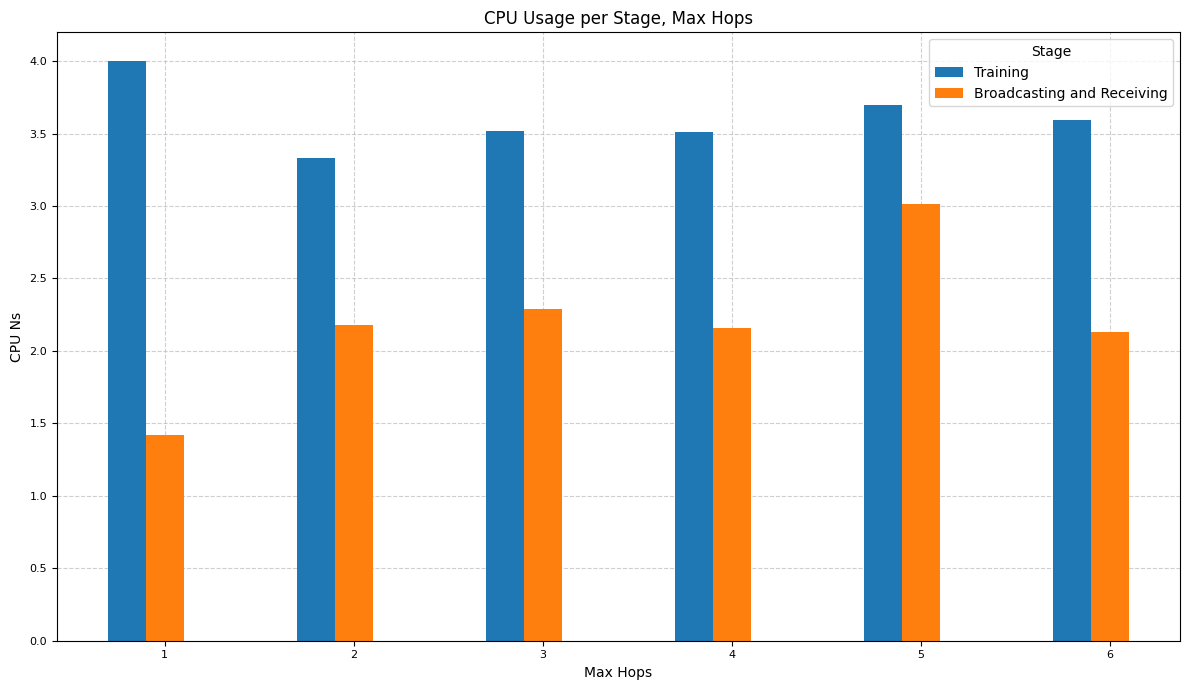

In [32]:
stage_plot(nr_batches, "Nr Batches", "nr_batches")
stage_plot(nr_nodes, "Nr Nodes", "nr_nodes")
stage_plot(nr_hops, "Max Hops", "max_hops")

In [33]:
# y: RTT
# x:
#   - delay in seconds
#   - number of hops

lambdas     = np.logspace(np.log10(0.001), np.log10(0.5), num=8)
print(lambdas)
nr_hops     = [1, 2, 3, 4, 5, 6]

def get_time_interval(df, prop, value):
    df_stage_3 = df[(df['field'] == prop) & (df['value'] == value)]

    node_stage_times = df_stage_3.groupby('node')['timestamp'].agg(['min', 'max'])

    start = node_stage_times['min'].max() + pd.Timedelta(seconds=2)
    end = node_stage_times['max'].min() - pd.Timedelta(seconds=2)

    return start, end

def get_avg_rtt(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601')

    max_peers = df[df['field'] == "active_peers"]["value"].max()
    start, end = get_time_interval(df, "active_peers", max_peers)

    df_interval = df[(df['timestamp'] > start) & (df['timestamp'] < end)]
    df_interval = df
    rtt_per_node = df_interval[df_interval['field'] == "last_rtt"].groupby('node')
    return rtt_per_node['value'].mean().mean()

def plot_avg_rtt(x_axis, title, folder, image_name, log=False):
    files = get_filenames_in_folder(join(metrics_path, folder))
    df_files = [read_file(f) for f in files]
    y_axis = [get_avg_rtt(df) for df in df_files]

    plt.figure(figsize=FIGURE_SIZE)
    plt.plot(x_axis[:len(y_axis)], y_axis, marker='o')

    # Add labels and title
    plt.xlabel(title)
    if log==True:
        plt.xscale('log')
    plt.ylabel('Average RTT (s)')
    plt.title(f'RTT by {title}')

    # Add grid and legend
    plt.grid(True)
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.savefig(join(figure_path, f"{image_name}.png"))
    plt.grid(**GRID_STYLE)
    plt.show()


[0.001      0.00242978 0.00590384 0.01434503 0.03485528 0.0846907
 0.20577986 0.5       ]


/tmp/ipykernel_2135/266689759.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


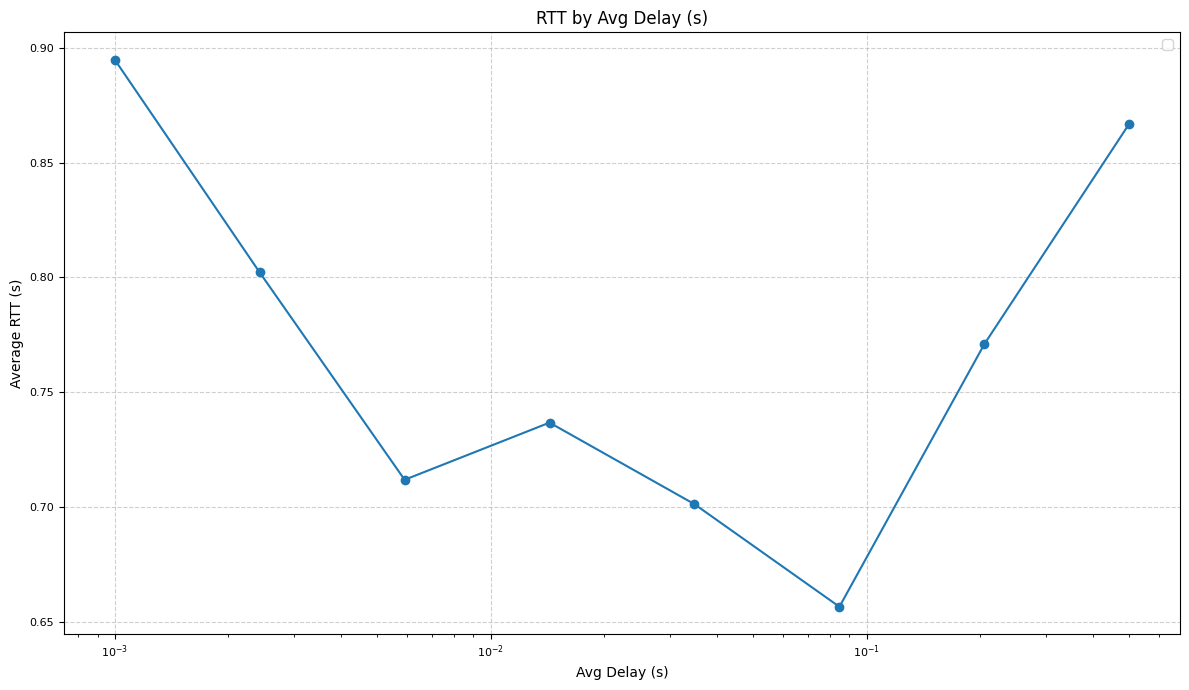

/tmp/ipykernel_2135/266689759.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


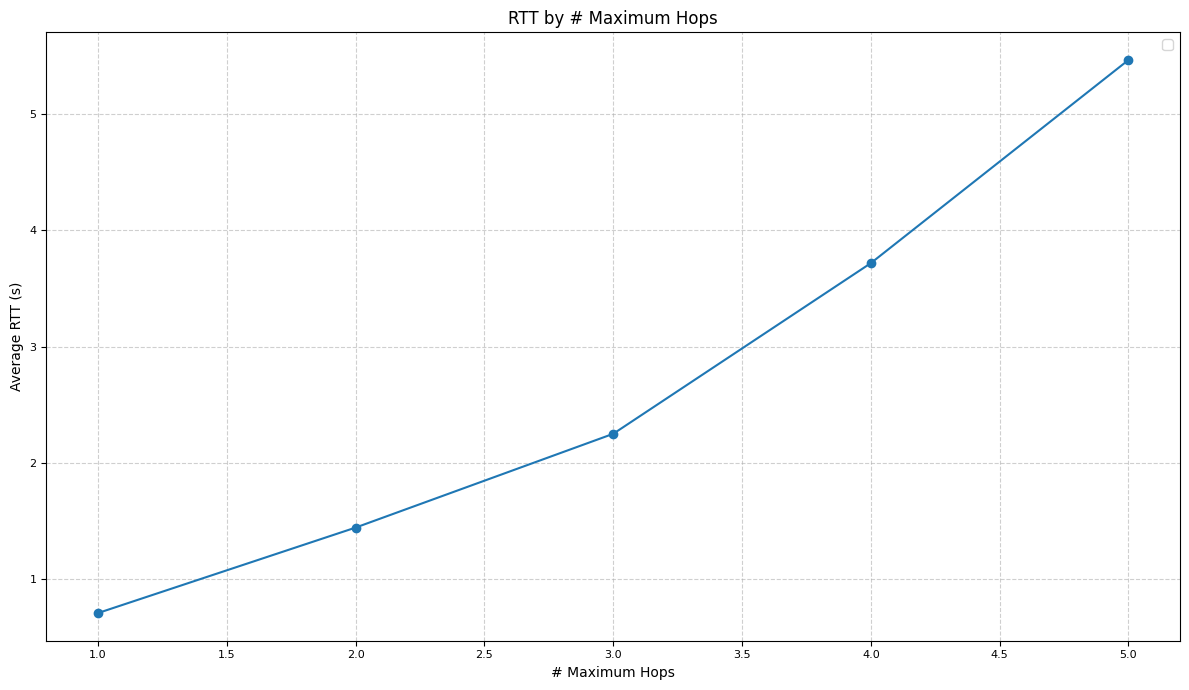

In [34]:
plot_avg_rtt(lambdas, "Avg Delay (s)", "rtts_per_lambda/ex02-10000", "rtts_per_lambda_last_rtt", log=True)
plot_avg_rtt(nr_hops, "# Maximum Hops", "rtts_per_hops/ex02", "rtts_per_hops_last_rtt")

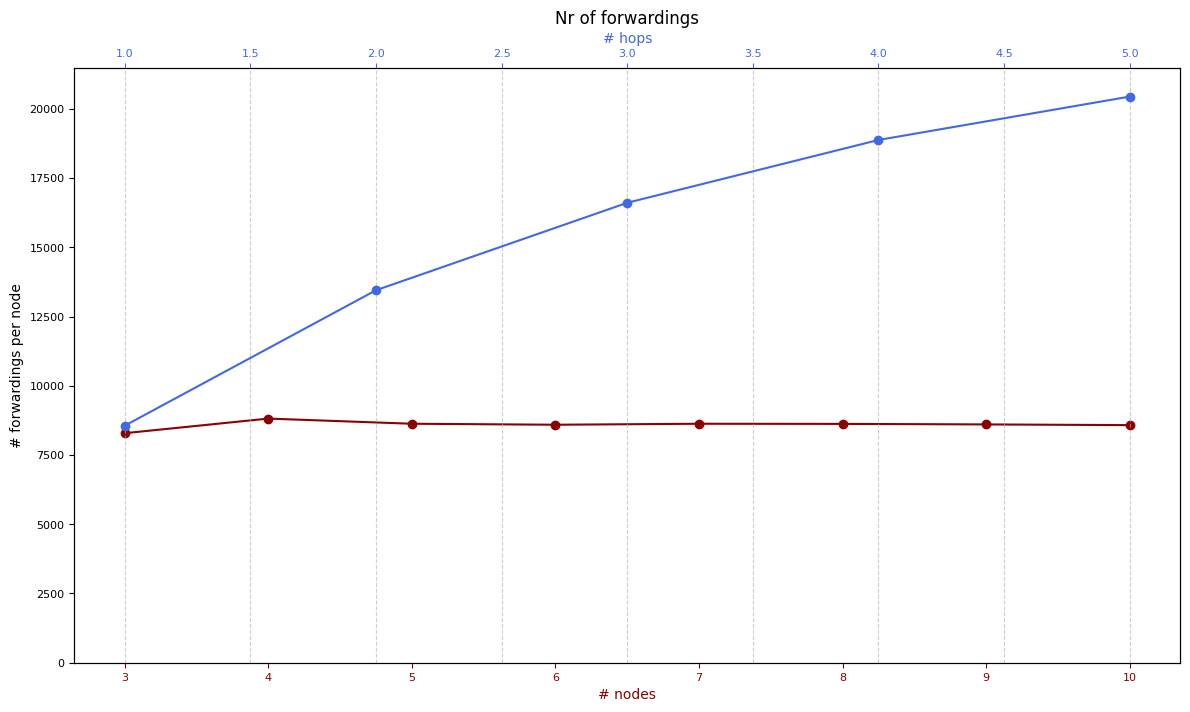

In [66]:
nr_nodes = range(3, 10 + 1)
nr_hops = range(1, 5 + 1)

def get_nr_forwardings(df):
    max_mean = df[df["field"] == "forwarded"].groupby("node")['value'].max().mean()
    return max_mean

def get_y_axis_values(folder):
    files = get_filenames_in_folder(join(metrics_path, folder))
    df_files = [read_file(f) for f in files]
    return [get_nr_forwardings(df) for df in df_files]

def plot_avg_forwardings(x_axis, y_axis, ax, xlabel, color):
    ax.plot(x_axis, y_axis, marker='o', color=color, label=xlabel)
    ax.set_xlabel(xlabel, color=color)
    ax.set_ylabel("# forwardings per node")
    ax.tick_params(axis='x', colors=color)

y_nodes = get_y_axis_values("nr_forwardings/per_nodes")
y_hops = get_y_axis_values("nr_forwardings/per_hops")

fig, ax1 = plt.subplots(figsize=FIGURE_SIZE)

plot_avg_forwardings(nr_nodes, y_nodes, ax1, "# nodes", color='darkred')
ax1.set_ylabel("# forwardings per node")
ax1.set_ylim(bottom=0, top=max(max(y_nodes), max(y_hops)) * 1.05)  # ✅ Fit both ranges

ax2 = ax1.twiny()
plot_avg_forwardings(nr_hops, y_hops, ax2, "# hops", color='royalblue')

plt.tight_layout()
plt.title("Nr of forwardings")
plt.grid(True, axis='y')
plt.savefig(join(figure_path, "nr_forwardings.png"))
plt.grid(**GRID_STYLE)
plt.show()


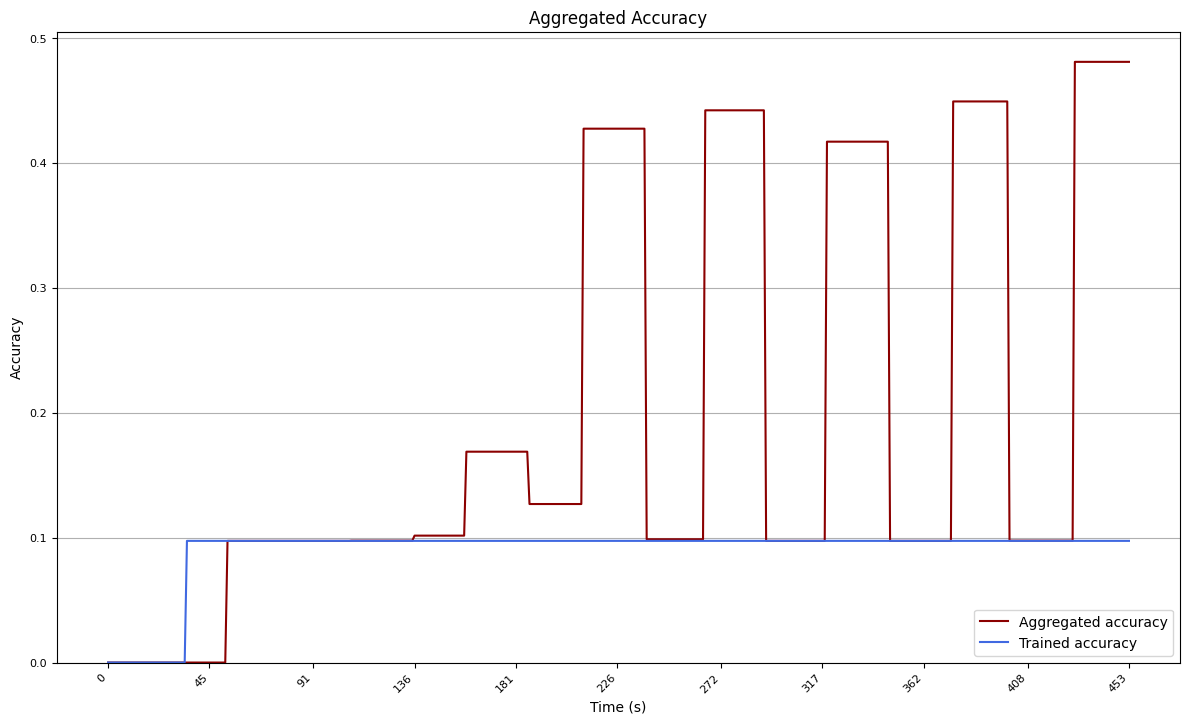

In [67]:
def plot_acc(node):
    filename = get_filenames_in_folder(join(metrics_path, "agg_accuracy"))[0]
    df = read_file(filename)

    timestamps = df[(df['node'] == node) & (df['field'] == 'aggregated_accuracy')]['timestamp']
    timestamps = pd.to_datetime(timestamps)

    # Convert to seconds starting at 0
    x_axis = (timestamps - timestamps.min()).dt.total_seconds()

    agg_acc = df[(df['node'] == node) & (df['field'] == 'aggregated_accuracy')]['value']
    acc = df[(df['node'] == node) & (df['field'] == 'accuracy')]['value']

    fig, ax = plt.subplots(figsize=FIGURE_SIZE)

    # ✅ Plot both lines on the same axis
    ax.plot(x_axis, agg_acc, color='darkred', label="Aggregated accuracy")
    ax.plot(x_axis, acc, color='royalblue', label="Trained accuracy")

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Accuracy")
    ax.set_ylim(bottom=0, top=max(max(agg_acc), max(acc)) * 1.05)

    # ✅ Show fewer ticks
    step = max(1, len(x_axis) // 10)
    ax.set_xticks(x_axis[::step])

    # ✅ Add legend in the upper-left corner (change loc as needed)
    ax.legend(loc="lower right")

    plt.tight_layout()
    plt.title("Aggregated Accuracy")
    plt.grid(True, axis='y')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.savefig(join(figure_path, "agg_accuracy.png"))
    plt.show()


plot_acc('node_0')
    


[ 0.1         0.31622777  1.          3.16227766 10.        ]
[0.3794  0.58828 0.84016 0.91538 0.92814]
[0.52604 0.74044 0.90208 0.92706 0.93148]


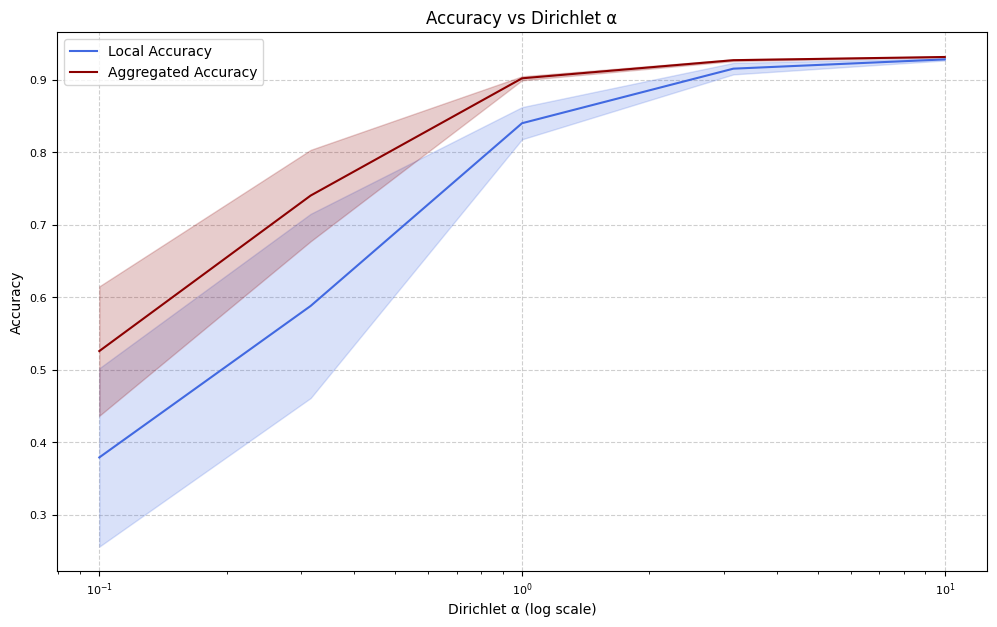

In [ ]:
alphas = np.logspace(-1, 1, num=5)
print(alphas)

plt.figure(figsize=FIGURE_SIZE)

files = get_filenames_in_folder(join(metrics_path, "acc_dirichlet"))
dfs = [read_file(f) for f in files]

def get_attr_per_node(df, attr):
    return df[df['field'] == attr].groupby('node').tail(1)['value']

local_mean = np.array([get_attr_per_node(df, 'accuracy').mean() for df in dfs])
local_std = np.array([get_attr_per_node(df, 'accuracy').std() for df in dfs])
agg_mean = np.array([get_attr_per_node(df, 'aggregated_accuracy').mean() for df in dfs])
agg_std = np.array([get_attr_per_node(df, 'aggregated_accuracy').std() for df in dfs])

print(local_mean)
print(agg_mean)

plt.plot(alphas, local_mean, color="royalblue", label="Local Accuracy")
plt.fill_between(alphas, local_mean - local_std, local_mean + local_std, color="royalblue", alpha=0.2)

plt.plot(alphas, agg_mean, color="darkred", label="Aggregated Accuracy")
plt.fill_between(alphas, agg_mean - agg_std, agg_mean + agg_std, color="darkred", alpha=0.2)

plt.tight_layout()
plt.xscale("log")
plt.xlabel("Dirichlet α (log scale)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Dirichlet α")
plt.legend()
plt.grid(**GRID_STYLE)
plt.savefig(join(figure_path, "agg_dirichlet.png"))
plt.show()
